In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = "data/train.p"
validation_file = "data/valid.p"
testing_file    = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test =X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))  #https://stackoverflow.com/a/12282286

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import pandas as pd
import numpy as np
import textwrap
from PIL     import Image
from os      import listdir
from os.path import isfile, join, basename

In [56]:
random.seed()

class Logger:
    
    def __init__(self, name, owner=None):
        if owner is not None:
            # https://stackoverflow.com/a/7983848
            name = name + "-" + str(id(owner))[-4:]
        
        self.name = name
        return
        
    def log(self, msg):
        print (self.name + " | " + msg)
        return


class SignNames_CSV:

    def __init__(self):
        self.df = pd.read_csv("signnames.csv")
        return
    
    def signName(self, class_id):
        return self.df.at[class_id, 'SignName']
    
signnames_csv = SignNames_CSV()


def signName(class_id):
    return signnames_csv.signName(class_id)


class TrafficSignsDataset:
    
    def __init__(self, *args):
        
        self.logger = Logger("TrafficSignsDataset", self)
        
        if len(args) == 3:
            # initialized with imags, labels and n_classes
            images, labels, n_classes = args
        else:
            # len args == 2
            # initializes with folder_name and n_classes
            folder_name, n_classes = args
            images, labels = self.loadFolder(folder_name)
            
        self.org_X = images
        self.org_y = labels
            
        self.X = self.org_X.copy()
        self.y = self.org_y.copy()
        
        self.n_classes = n_classes
        
        return

    def loadFolder(self, folder_name):
    
        msg = "Loading signs from {}..."
        self.logger.log(msg.format(folder_name))

        pathnames = [join(folder_name, f) 
                     for f in listdir(folder_name) if isfile(join(folder_name, f))]

        n = 0
        images = []
        labels = []

        for pathname in pathnames:
            
            filename = basename(pathname) 
            classId = filename.split(",")[0]

            pil_img = Image.open(pathname).convert('RGB')
            
            pil_img20x20 = pil_img.resize((20, 20), Image.BILINEAR)
            img = np.pad (np.array(pil_img20x20), [(6, 6), (6, 6), (0, 0)])
            
            '''
            #if not padding, use:
            pil_img32x32 = pil_img.resize((32, 32), Image.BILINEAR)
            img = np.array(pil_img32x32)
            '''

            labels.append(classId)
            images.append(img)

            msg = "Loaded {} with label {}."
            self.logger.log(msg.format(filename, classId))

            n += 1

        msg = "...{} signs loaded."
        self.logger.log (msg.format(n))
        
        return images, labels
    
    def data(self):
        return (self.X, self.y)
    
    def processImages(self, img_processors):
        
        self.logger.log("Processing images...")
        
        for img_processor in img_processors:
            
            msg = "Applying {}() to images."
            self.logger.log(msg.format(img_processor.__name__))
            
            self.X = [img_processor(img) for img in self.X]
            
        self.logger.log("...images processed.")            
        
        return
    
    def addFakes (self, img_processors):
        
        self.logger.log("Adding fake images...")
        max_samples = np.max(np.bincount(self.y))
        
        for classId in range(self.n_classes):

            x = self.X[self.y == classId]
            y = self.y[self.y == classId]

            n_x = x.shape[0]

            aug_x = np.array([])
            aug_y = np.array([])

            if n_x < max_samples:

                n_repeats = (max_samples - n_x) // n_x
                n_remain = (max_samples - n_x) % n_x

                aug_x = np.repeat(x, n_repeats, axis=0)
                aug_x = np.concatenate ((aug_x, x[:n_remain]))
                for img_processor in img_processors:
                    aug_x = np.array([img_processor(img) for img in aug_x])

                aug_y = np.repeat(y, n_repeats, axis=0)
                aug_y = np.concatenate ((aug_y, y[:n_remain]))
                
                samples_added = max_samples - n_x
                msg = "Added {} fake images for sign classId {}."
                self.logger.log(msg.format(samples_added, classId))
                
            if aug_x.shape[0] > 0:
                self.X = np.concatenate((self.X, aug_x))
                self.y = np.concatenate((self.y, aug_y))
                
        self.X = np.array(self.X, dtype=np.uint8)
        self.logger.log ("...fake images added.")

        return
    
    def restoreOrgImages(self):
        
        self.X = np.array(self.org_X, dtype=np.uint8)
        self.y = np.array(self.org_y)
        
        self.logger.log("Original images and labels restored.")
        
        return
    
class Viewer:
    
    def __init__(self):
        return
    
    def imShowTrainingSigns(self, trainingSigns):
        
        ds = list(zip(trainingSigns.y, trainingSigns.X))
        df = pd.DataFrame(data=ds, columns=['Label', 'Image'])

        for classId in range(trainingSigns.n_classes):
            # https://pandas.pydata.org/pandas-docs/version/0.15/cookbook.html#building-criteria
            df_sel = df.loc[(df['Label'] == classId), 'Image'].sample(3)
            fig = plt.figure(figsize=(11, 3))
            fig.suptitle(signName(classId))
            for i in range(3):
                ax = plt.subplot(1, 3, i + 1)
                ax.imshow(df_sel.iloc[i])
            plt.show()    
        
        return
    
    def imShowTrainingSigns5x5(self, trainingSigns):
        fig = plt.figure(figsize=(11,11))
        num_rows = 5
        num_cols = 5
        for i in range(num_cols*num_rows):
            img = random.choice(trainingSigns.X)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            ax.imshow(img)
        plt.show()
        return

    def barhPctBySigns(self, trainingSigns, validSigns, testSigns):
        y_train = trainingSigns.y
        y_valid = validSigns.y
        y_test  = testSigns.y
        
        bincount_y_train = np.bincount(y_train)
        bincount_y_valid = np.bincount(y_valid)
        bincount_y_test  = np.bincount(y_test)
        # bin_count[i] = num samples for sign i (where i=classId)

        pct_y_train = bincount_y_train / sum(bincount_y_train)
        pct_y_valid = bincount_y_valid / sum(bincount_y_valid)
        pct_y_test  = bincount_y_test  / sum(bincount_y_test)
        # pct_y_train[i] = percentage of total samples of sign i 

        pct_y_train_sorted_idx = np.argsort(pct_y_train)
        # pct_y_train_sorted_idx an array of sign classIds sorted by their percentage

        # ref: https://stackoverflow.com/a/59421062
        bar_wid = 0.3

        y_pos      = np.arange(len(pct_y_train))
        pcts       = [pct_y_train[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_valid = [pct_y_valid[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_test  = [pct_y_test[class_id] for class_id in pct_y_train_sorted_idx]
        y_labels   = [textwrap.fill(signName(class_id), width=25) 
                      for class_id in pct_y_train_sorted_idx]

        fig, ax = plt.subplots(figsize=(11, 35))

        ax.barh(y_pos + 2*bar_wid, pcts,       bar_wid, label="Training")
        ax.barh(y_pos + bar_wid,   pcts_valid, bar_wid, label="Valid")
        ax.barh(y_pos,             pcts_test,  bar_wid, label="Test")

        ax.set_yticks(y_pos  + bar_wid)
        ax.set_yticklabels(y_labels)
        ax.set_xlabel('Percentage of Sample')
        ax.set_title("Percentage of Sample by Sign and Dataset")

        plt.legend(loc='best')
        plt.margins(y=0)
        plt.show()

        return
    
    def barhCountTrainingSigns(self, trainingSigns):
        sign_count_y_train = np.bincount(trainingSigns.y)

        # ref: https://stackoverflow.com/a/59421062
        y_pos        = np.arange(len(sign_count_y_train))
        counts_train = [sign_count_y_train[class_id] 
                        for class_id in range(trainingSigns.n_classes)]
        
        y_labels     = [textwrap.fill(signName(class_id), width=25) 
                        for class_id in range(trainingSigns.n_classes)]

        fig, ax = plt.subplots(figsize=(11, 35))

        # ax.barh(y_pos, counts_train)
        ax.barh(y_pos, counts_train)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.invert_yaxis()
        ax.set_xlabel('Number of Training Samples')
        ax.set_title("Number of Training Samples by Sign")

        plt.margins(y=0)
        plt.show()

        return        
    
    def imShowPredictions(self, images, predictions):
        
        num_images = len(images)
        
        fig, axs = plt.subplots(num_images, 2, figsize=(15, 3.5*num_images))
        if num_images == 1:
            axs = [axs]
        
        for ax, img, vals, idxs in zip(axs, images, predictions.values, predictions.indices):
            
            pcts  = [100*v for v in vals]
            signs = [textwrap.fill(signName(i), width=25) for i in idxs]
            
            # https://matplotlib.org/gallery/lines_bars_and_markers/barh.html#sphx-glr-gallery-lines-bars-and-markers-barh-py
            img_ax = ax[0]
            bar_ax = ax[1]

            img_ax.imshow(img)
            img_ax.set_title("Image of Sign")
            
            ypos = np.arange(len(signs))
            bar_ax.barh(ypos, pcts)
            bar_ax.set_yticks(ypos)
            bar_ax.set_yticklabels(signs)
            bar_ax.invert_yaxis()
            bar_ax.set_xlabel("Confidence")
            bar_ax.set_title("Classification (Top 5)")
            bar_ax.set_xlim([0,100])

        fig.suptitle("Model Classification of some German Traffic Signs", y = 1.0)
        fig.tight_layout()
        plt.show()    
        
        return
    
    def imShowConvOutputs(self, conv_outputs):

        # layer_ouputs in shape (1, ?, ?, depth)
        features = layer_outputs[0]
        depth = layer_outputs.shape[3]
        
        plt.figure(figsize=(15, (2.5 * (depth//8 + 1))))

        n_cols = 8
        n_rows = depth//n_cols + 1
        
        for level in range(depth):
            
            img = features[:,:,level] * 255
            
            plt.subplot(n_rows, n_cols, level + 1)
            plt.imshow(img, 
                       interpolation='nearest', 
                       cmap='gray',
                       vmin=np.amin(img), vmax=np.amax(img))
            
        return
    
    def plotAccHist(self, model_name, acc_hist):
        
        epoch = [e for e in range(len(acc_hist))]
        
        plt.plot(epoch, acc_hist)
        plt.title("Accuracy over Epoch for " + model_name)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()
        
        return
        
        

trainingSigns = TrafficSignsDataset(X_train, y_train, n_classes)
validSigns    = TrafficSignsDataset(X_valid, y_valid, n_classes)
testSigns     = TrafficSignsDataset(X_test, y_test, n_classes)
vwr           = Viewer()


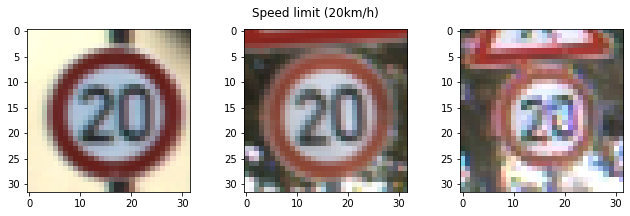

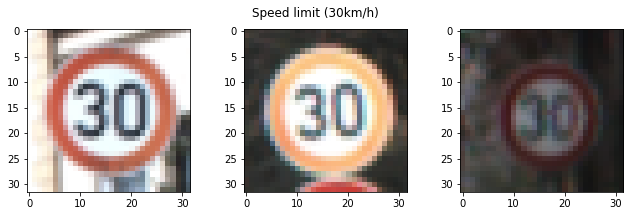

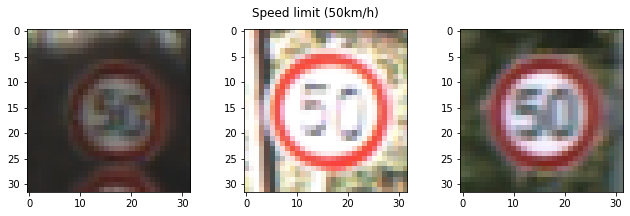

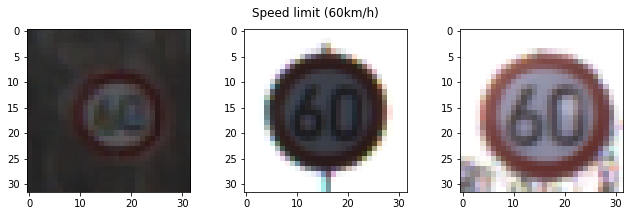

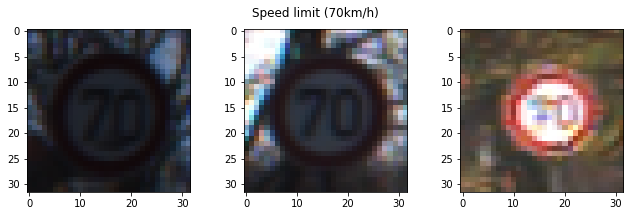

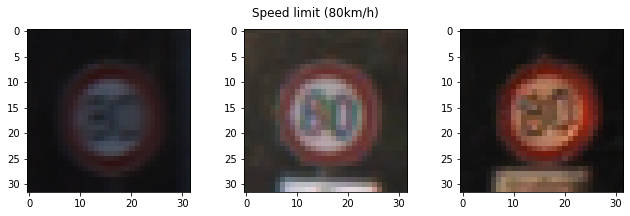

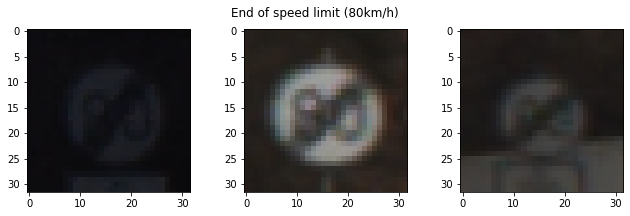

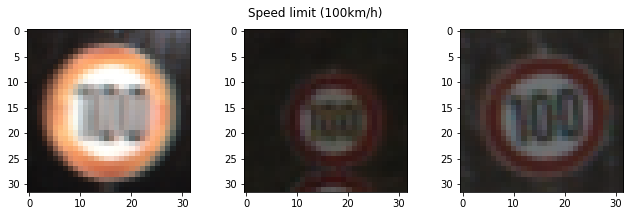

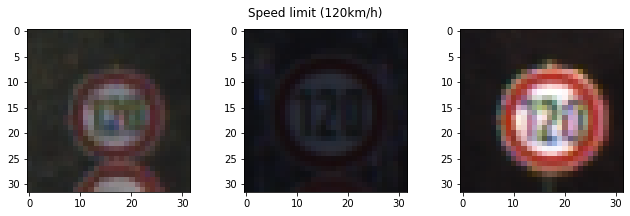

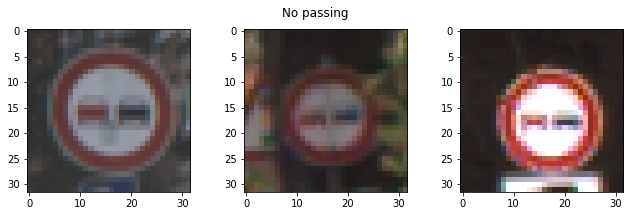

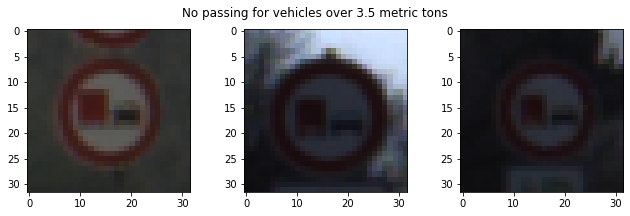

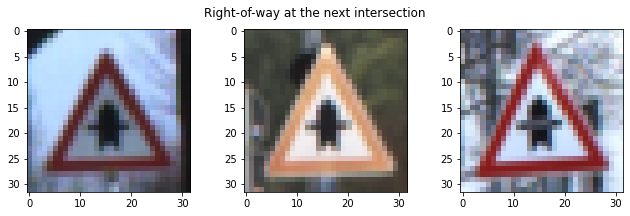

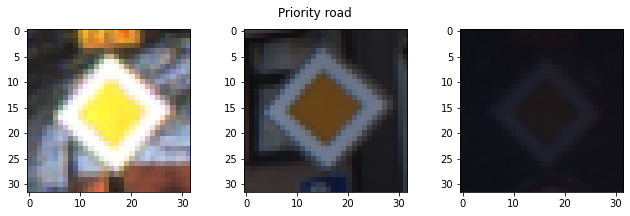

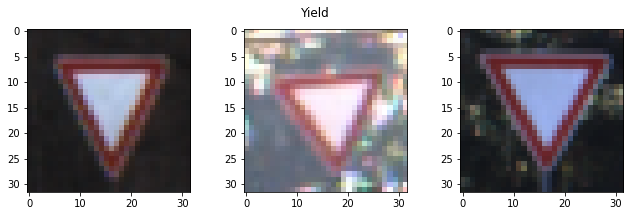

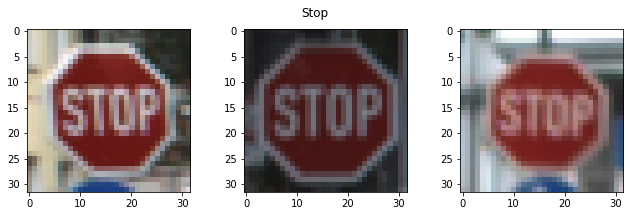

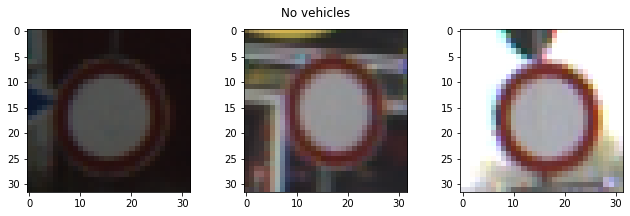

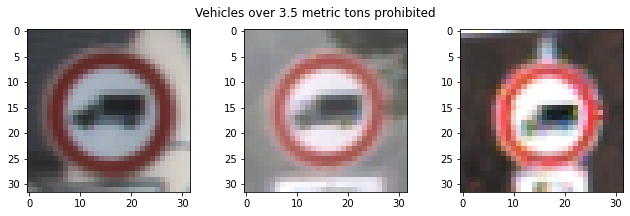

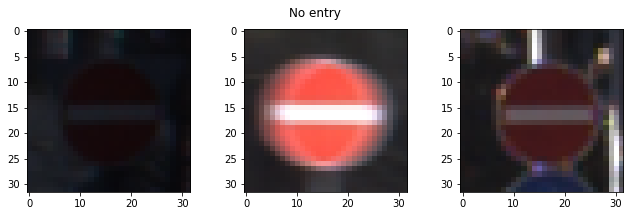

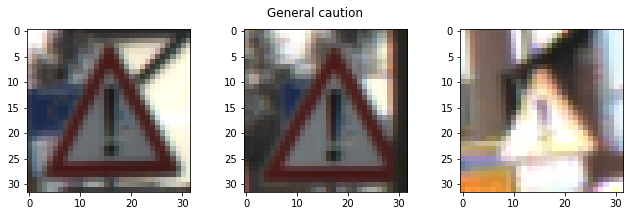

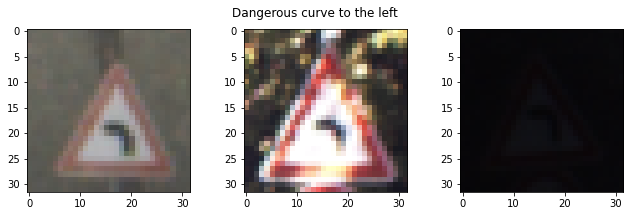

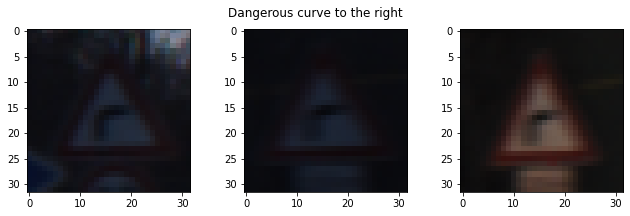

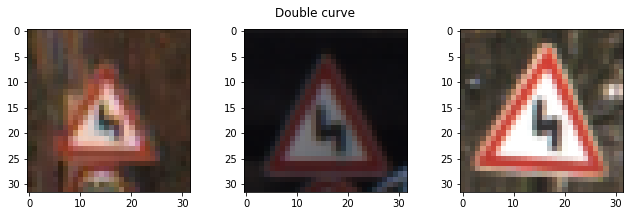

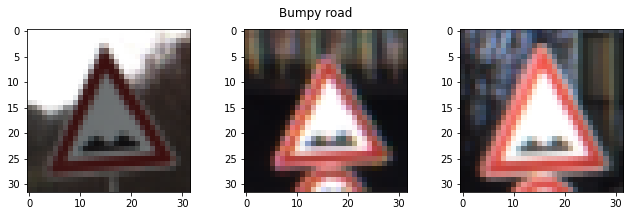

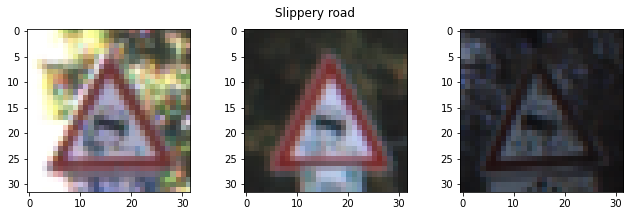

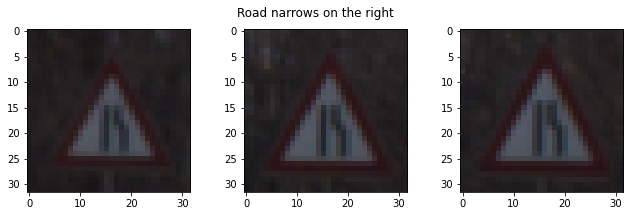

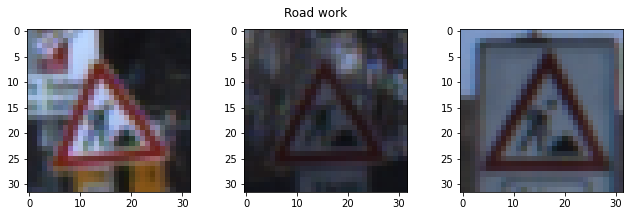

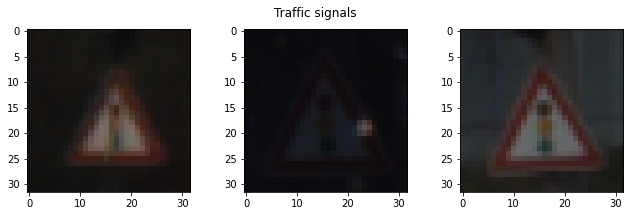

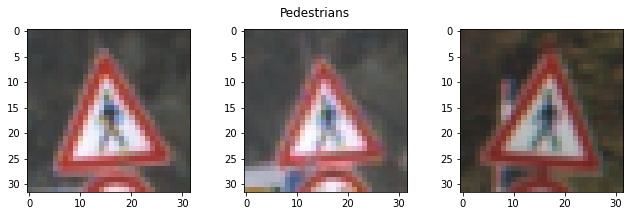

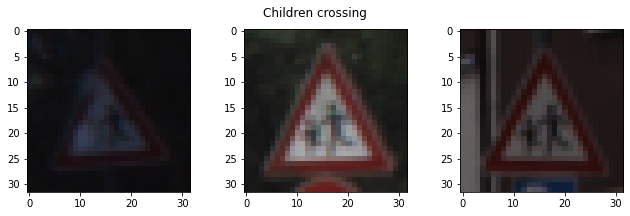

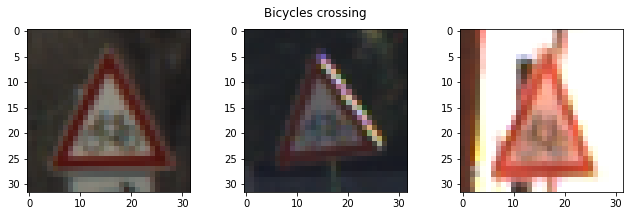

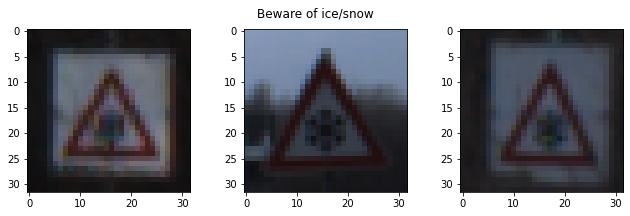

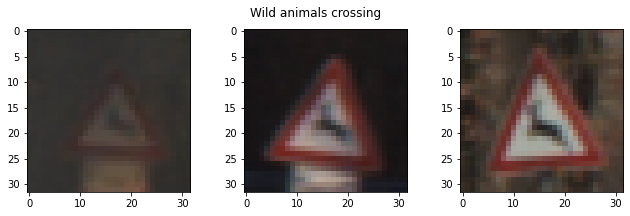

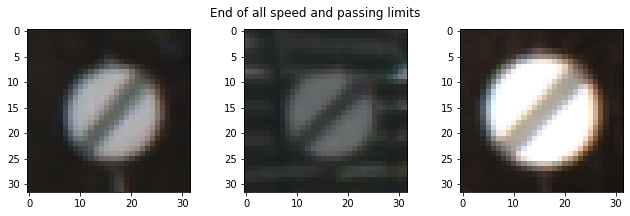

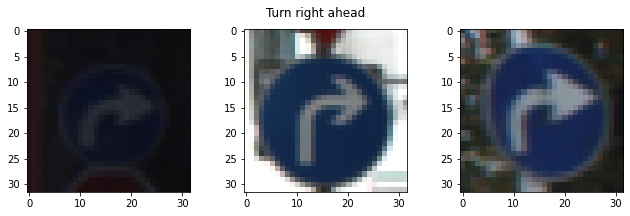

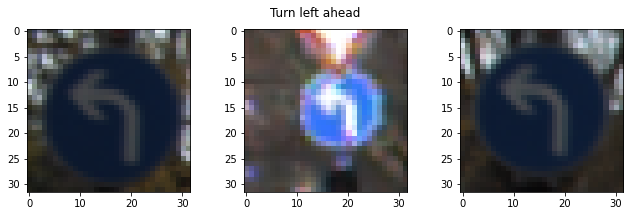

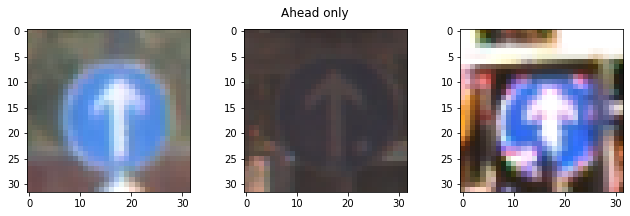

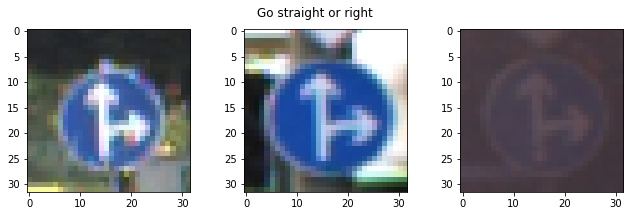

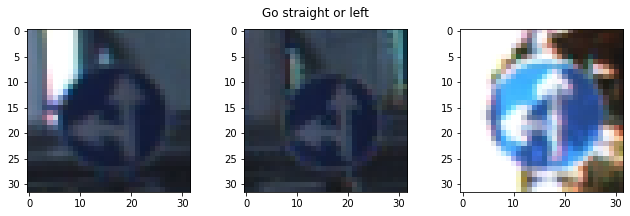

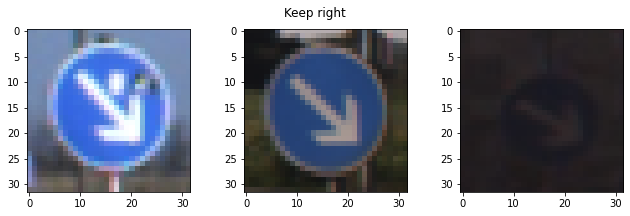

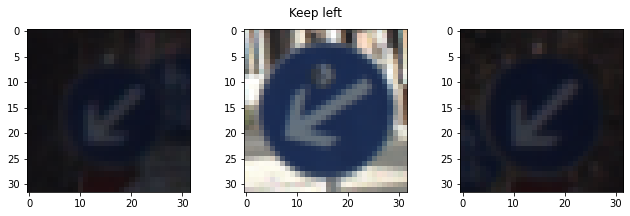

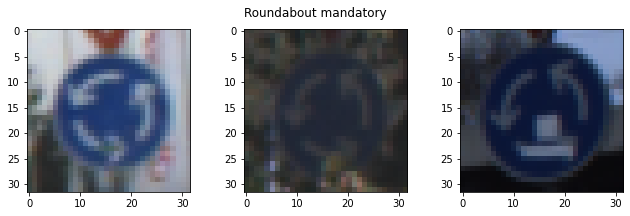

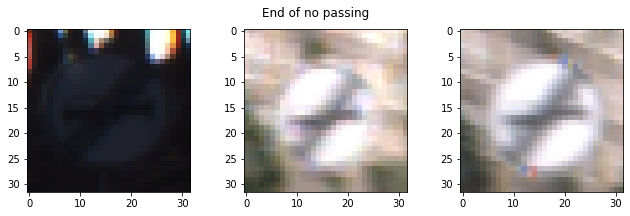

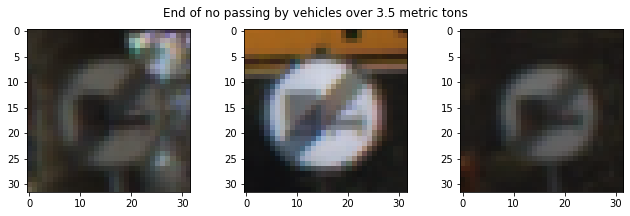

In [5]:
vwr.imShowTrainingSigns(trainingSigns)

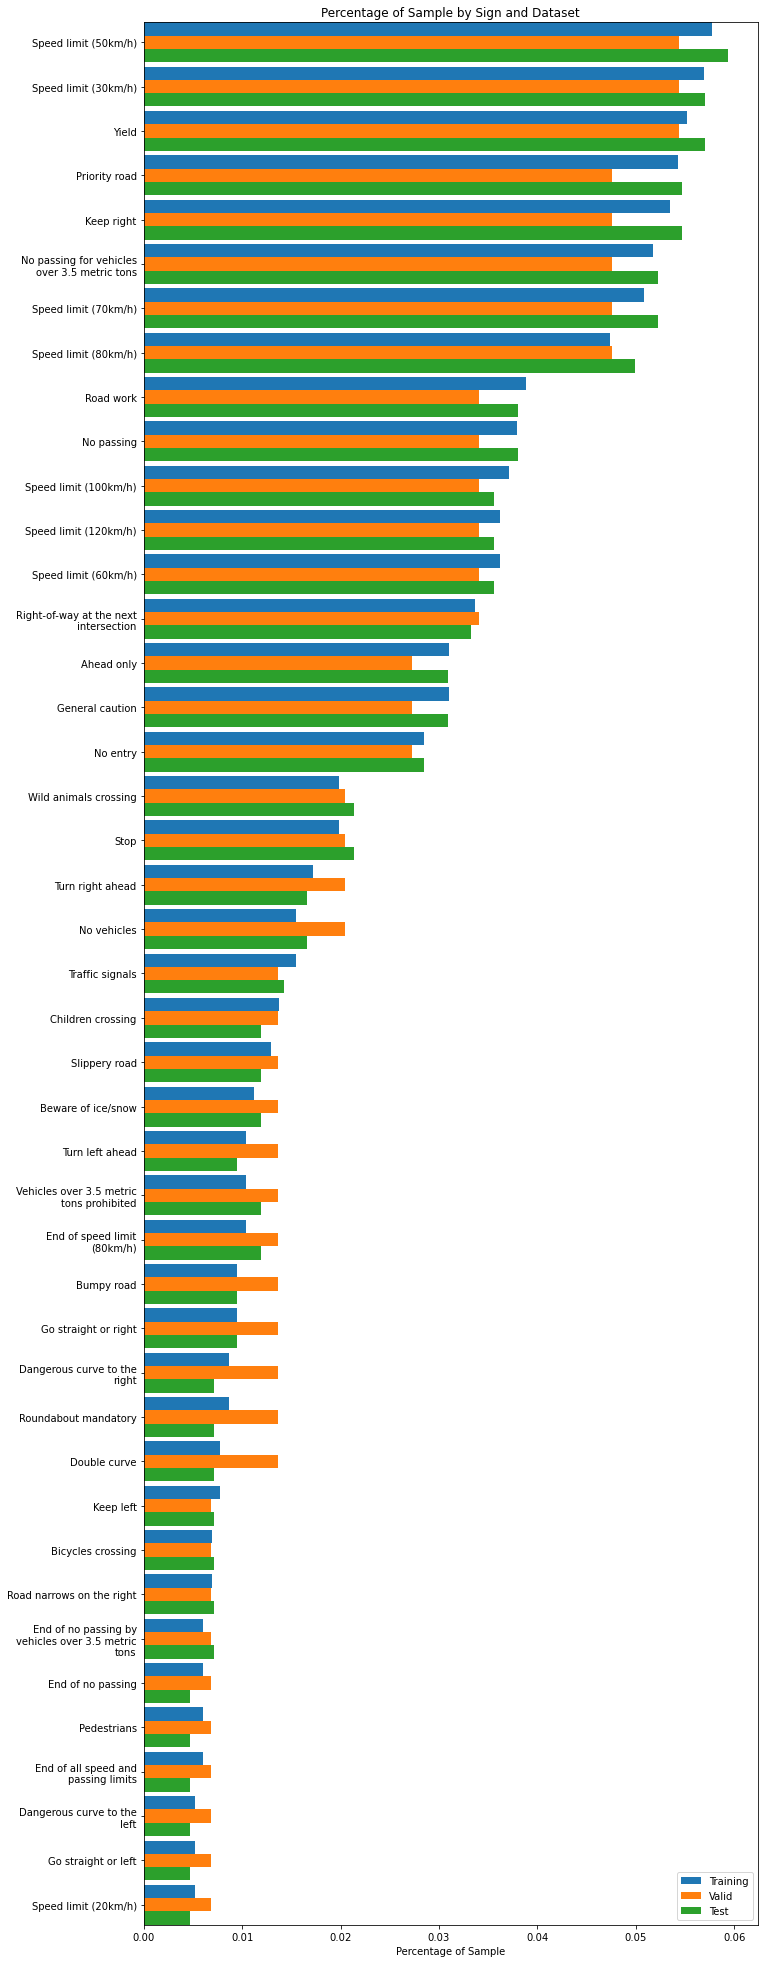

In [6]:
vwr.barhPctBySigns(trainingSigns, validSigns, testSigns)

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2
import skimage as sk
from skimage.transform import rotate

In [11]:
def RGB_to_norm(img):
    return (np.float32(img) - 128)/128

def norm_to_RGB(norm_img):
    return (np.uint8(128 * norm_img) + 128)

def equalizeHist(orgimg, v_thresh=128): #84
    hsv = cv2.cvtColor(orgimg, cv2.COLOR_RGB2HSV)
    mean_v = np.mean(hsv[:,:,2])
    if mean_v < v_thresh:
        equ = cv2.equalizeHist(hsv[:,:,2])
        hsv[:,:,2] = equ
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        img = orgimg
    return img

image_processors = [equalizeHist, RGB_to_norm]

# https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

def shift(image):
    d = random.randint(1, 6)
    direction = random.choice([1, 2, 3, 4])
    if direction == 1:
        image[:-d] = image[d:]
    elif direction == 2:
        image[d:] = image[:-d]
    elif direction == 3:
        image[:,d:] = image[:,:-d]
    else:
        image[:,:-d] = image[:,d:]
        
    return image

def crop(image, size=32):
    sizes = np.array(image.shape[:2]) - 32
    lower =  sizes // 2
    upper = image.shape[:2] - (lower + (sizes % 2))
    img = image[lower[0]:upper[0], lower[1]:upper[1]]
    return img

def zoom(image):
    scale = random.uniform(1.0, 1.6)
    img = sk.transform.rescale(image, scale, multichannel=True, preserve_range=True).astype(np.uint8)
    return crop(img)

def rotate (image):
    deg = random.uniform(-15, 15)
    return sk.transform.rotate(image, deg, preserve_range=True).astype(np.uint8)

def preserve(image):
    return image.astype(np.uint8)

def fakeify(image):
    f = random.choices ([preserve, rotate, zoom, shift], weights=[1, 1, 1, 1])[0]
    return f(image)


(32, 32, 3)
1.0179579209323002


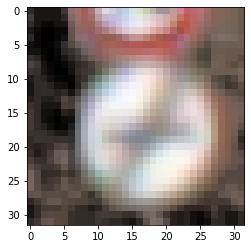

In [9]:
image = trainingSigns.X[0]
print(image.shape)
image = equalizeHist(image)
image = zoom(image)

plt.imshow(image)

In [12]:
trainingSigns.restoreOrgImages()
trainingSigns.addFakes([fakeify])

TrafficSignsDataset-0512 | Original images and labels restored.
TrafficSignsDataset-0512 | Adding fake images...
TrafficSignsDataset-0512 | Added 1830 fake images for sign classId 0.
TrafficSignsDataset-0512 | Added 30 fake images for sign classId 1.
TrafficSignsDataset-0512 | Added 750 fake images for sign classId 3.
TrafficSignsDataset-0512 | Added 240 fake images for sign classId 4.
TrafficSignsDataset-0512 | Added 360 fake images for sign classId 5.
TrafficSignsDataset-0512 | Added 1650 fake images for sign classId 6.
TrafficSignsDataset-0512 | Added 720 fake images for sign classId 7.
TrafficSignsDataset-0512 | Added 750 fake images for sign classId 8.
TrafficSignsDataset-0512 | Added 690 fake images for sign classId 9.
TrafficSignsDataset-0512 | Added 210 fake images for sign classId 10.
TrafficSignsDataset-0512 | Added 840 fake images for sign classId 11.
TrafficSignsDataset-0512 | Added 120 fake images for sign classId 12.
TrafficSignsDataset-0512 | Added 90 fake images for sig

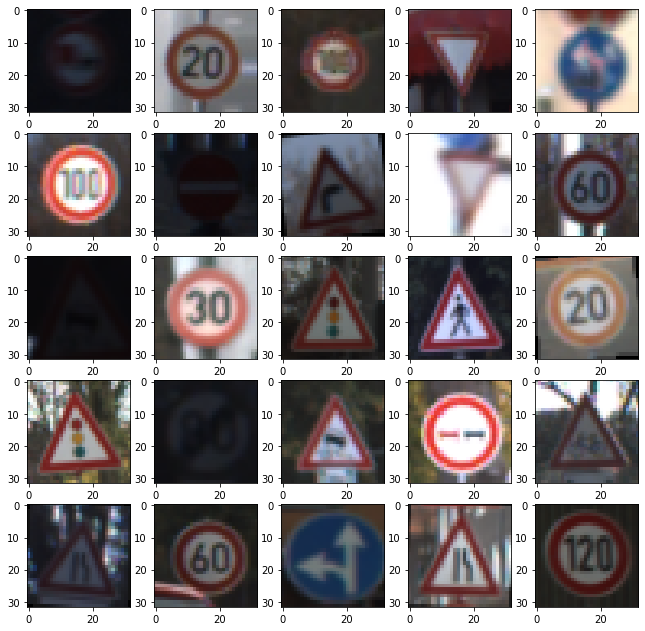

In [13]:
vwr.imShowTrainingSigns5x5(trainingSigns)

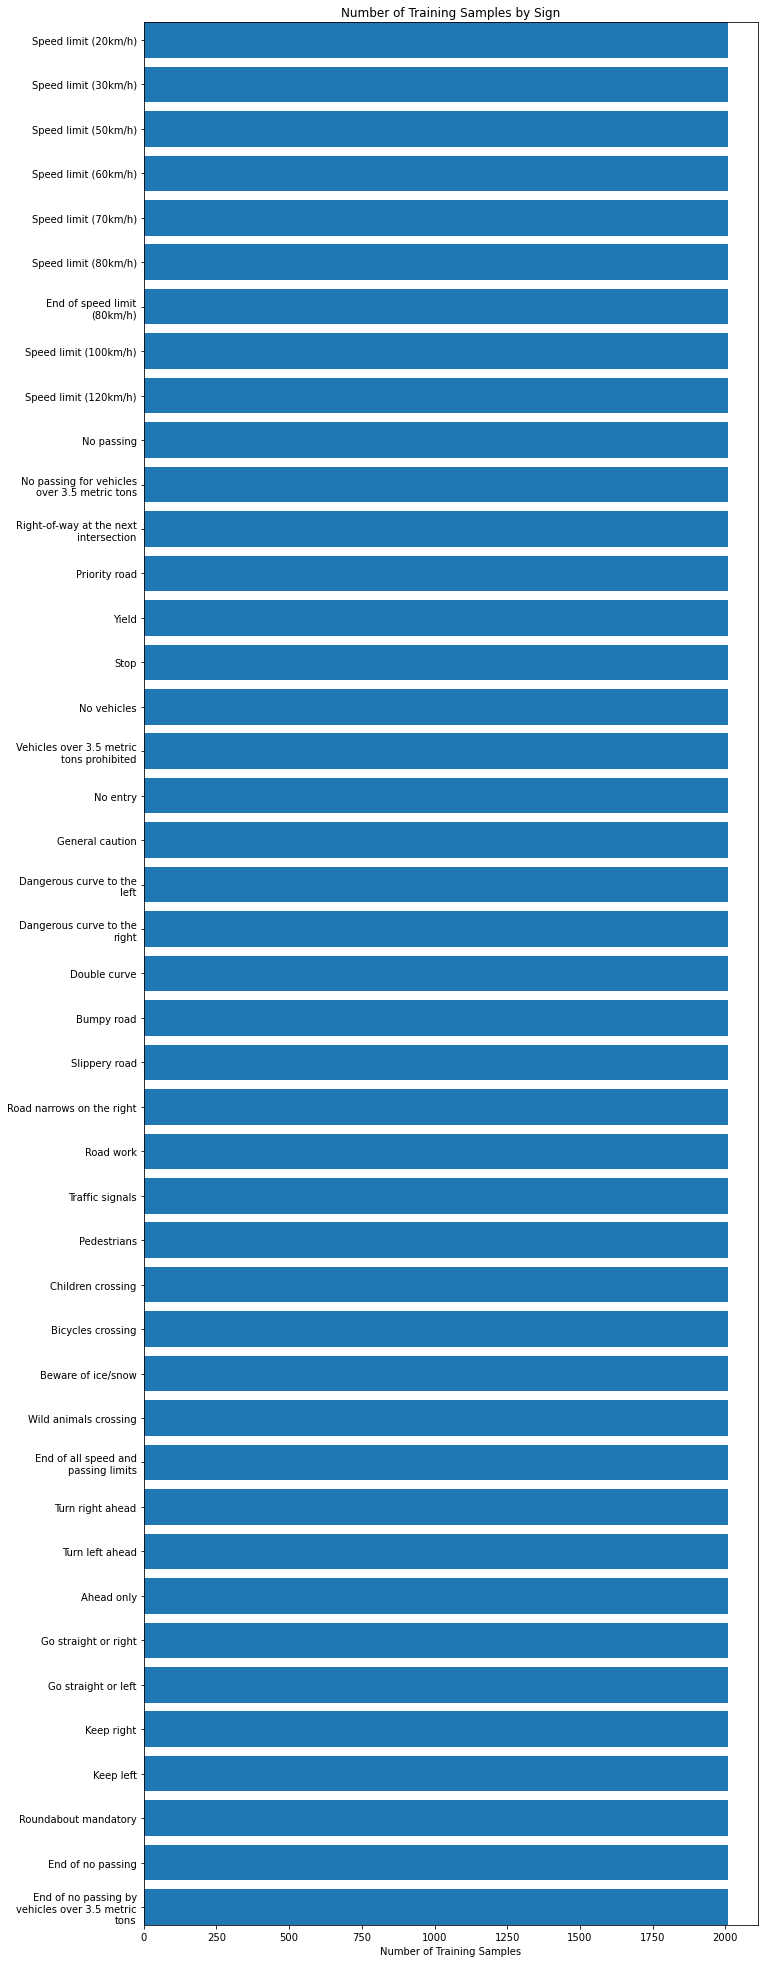

In [14]:
vwr.barhCountTrainingSigns(trainingSigns)

In [15]:
trainingSigns.processImages(image_processors)

validSigns.restoreOrgImages()
validSigns.processImages(image_processors)

testSigns.restoreOrgImages()
testSigns.processImages(image_processors)

TrafficSignsDataset-0512 | Processing images...
TrafficSignsDataset-0512 | Applying equalizeHist() to images.
TrafficSignsDataset-0512 | Applying RGB_to_norm() to images.
TrafficSignsDataset-0512 | ...images processed.
TrafficSignsDataset-0376 | Original images and labels restored.
TrafficSignsDataset-0376 | Processing images...
TrafficSignsDataset-0376 | Applying equalizeHist() to images.
TrafficSignsDataset-0376 | Applying RGB_to_norm() to images.
TrafficSignsDataset-0376 | ...images processed.
TrafficSignsDataset-0640 | Original images and labels restored.
TrafficSignsDataset-0640 | Processing images...
TrafficSignsDataset-0640 | Applying equalizeHist() to images.
TrafficSignsDataset-0640 | Applying RGB_to_norm() to images.
TrafficSignsDataset-0640 | ...images processed.


In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from PIL import Image

W0206 00:46:08.725815 20108 __init__.py:329] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [17]:
def conv2D(x, output_shape, s=1, mu=0, sigma=0.1, activation=tf.nn.relu):
    
    input_shape = x.shape.as_list()[1:]
    
    input_depth  = input_shape[2]
    output_depth = output_shape[2]
    
    stride = [1, s, s, 1]
    
    # size of filter (length=Width)
    # ref: lesson 12: Solution: Convolution Output Shape for "VALID" padding
    f_ht  = input_shape[0] - output_shape[0]*s + 1
    f_wid = input_shape[1] - output_shape[1]*s + 1
    
    # shape of weights
    w_shape = (f_ht, f_wid, input_depth, output_depth)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_depth))
    c = tf.nn.conv2d(x, w, stride, padding='VALID') + b
    a = activation(c)
    
    return a


def pooling(x, output_shape, s=2, pool=tf.nn.max_pool):
    
    input_shape = x.shape.as_list()[1:]
    input_depth = input_shape[2]
    
    # size of filter
    # ref: lesson 23: Quiz: Pooling Mechanics
    f_ht  = input_shape[0] - (output_shape[0] - 1) * s
    f_wid = input_shape[1] - (output_shape[1] - 1) * s
    
    fil    = [1, f_ht, f_wid, 1]
    stride = [1, s, s, 1]
    
    p = pool(x, fil, stride, padding='VALID')
    
    return p


def connected(x, output_shape,  mu=0, sigma=0.1, activation=tf.nn.relu):
    input_shape = x.shape.as_list()[1]
    output_shape = output_shape[0]
    w_shape = (input_shape, output_shape)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_shape))
    z = tf.add(tf.matmul(x, w), b)
    
    if activation is None:
        a = z
    else:
        a = activation(z)
    
    return a


In [18]:
class Layer():
    def __init__(self, output_shape=None):
        self.output_shape = output_shape
        self.tensor = None
        self.model = None
        self.setName()
        return
    
    def setName(self):
        self.name = "Layer"
        return
    
    def summary(self):
        return self.name.ljust(10) + ":" + str(self.tensor.shape)
    
    def connect(self, *prev_layers):
        self.tensor = prev_layers[0].tensor
        return self
    
    def owner(self, model = None):
        if model is not None:
            self.model = model
        return self.model

    
class Input(Layer):
    
    def __init__(self, X):
        
        super().__init__(self)
        self.tensor = X
        
    def setName(self):
        self.name = "Input"
        return
    
    
class Conv2D(Layer):

    def setName(self):
        self.name = "Conv2D"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = conv2D(prev_layer[0].tensor, self.output_shape)
        return self
    

class Pooling(Layer):
    
    def setName(self):
        self.name = "Pooling"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = pooling(prev_layer[0].tensor, self.output_shape)
        return self
    
    
class Dropout(Layer):
    
    def setName(self):
        self.name = "Dropout"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.keep_prob = self.model.keep_prob
        self.tensor = tf.nn.dropout(prev_layer[0].tensor, self.keep_prob)
        return self
    

class Flatten(Layer):
    
    def setName(self):
        self.name = "Flatten"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = flatten(prev_layer[0].tensor)
        return self
    
    
class Connected(Layer):

    def setName(self):
        self.name = "Connected"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = connected(prev_layer[0].tensor, self.output_shape)
        return self


In [19]:
class Model:
    
    def __init__(self, name, input_shape, n_classes):
        self.logger = Logger('Model', self)
        
        self.name = name
        
        x_shape = (None, input_shape[0], input_shape[1], input_shape[2])
        self.x  = tf.placeholder(tf.float32, x_shape)
        
        self.input_layer = Input(self.x)
        self.input_layer.owner(self)
        
        self.y         = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)

        self.n_classes = n_classes
        self.logits    = None
        self.saver     = None 
        self.acc_history = None
        
        return
    
    def inputLayer(self):
        return self.input_layer
    
    def connectLogits(self, prev_layer):
    
        self.logits = connected(prev_layer.tensor, [self.n_classes], activation=None)

        oh_labels      = tf.one_hot(self.y, self.n_classes)
        losses         = tf.nn.softmax_cross_entropy_with_logits(labels=oh_labels, logits=self.logits)
        self.mean_loss = tf.reduce_mean(losses)
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(oh_labels, 1))
        self.tot_correct   = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
    
    def accuracy(self, X_data, y_data, batch_size):
        
        num_examples = len(X_data)
        total_correct = 0
        sess = tf.get_default_session()        
        
        for offset in range(0, num_examples, batch_size):
            
            batch_x   = X_data[offset:offset+batch_size] 
            batch_y   = y_data[offset:offset+batch_size]
            feed_dict = {self.x: batch_x, 
                         self.y: batch_y, 
                         self.keep_prob: 1.0}
            
            batch_correct = sess.run(self.tot_correct, feed_dict=feed_dict)
            total_correct += batch_correct
            
        return round (total_correct / num_examples, 3)
    
    def saveModel(self):
        
        sess = tf.get_default_session()
        self.saver.save(sess, "checkpoints/" + self.name)
        msg = "{} saved."
        self.logger.log(msg.format(self.name))
        
        return
    
    def afterEpoch(self, epoch, i, acc, acc_save, hi_acc):
        self.acc_history.append(acc)
        i += 1
        if acc > acc_save:
            if acc > hi_acc:
                i = 0
                hi_acc = acc
                msg = "Epoch {:4d} - New High Acc: {:.3f}"
                self.logger.log(msg.format(epoch + 1, hi_acc))
                
                self.saveModel()
            else:
                msg = "Epoch {:4d} - Acc: {:.3f} - Highest: {:.3f}"
                self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        elif hi_acc > 0:
            msg = "Epoch {:4d} -  Acc: {:.3f} - Highest: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        else:
            msg = "Epoch {:4d} - Acc: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc))

        epoch += 1
            
        return epoch, i, hi_acc
    
    def train(self, training_data, validation_data, epochs_done, batch_size, lr=0.001, 
              acc_save=0.93, acc_done=0.982, keep_prob=1.0, ):
        
        X_train = training_data[0]
        y_train = training_data[1]
        
        X_valid = validation_data[0]
        y_valid = validation_data[1]
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        minimizer = optimizer.minimize(self.mean_loss)
        
        self.saver = tf.train.Saver()
        
        self.logger.log("Training...")
        with tf.Session() as sess:
            try:
            
                sess.run(tf.global_variables_initializer())

                num_examples = len(X_train)

                self.acc_history = []
                hi_acc = 0
                epoch = 0
                i = 0
                acc = 0
                while (i < epochs_done) and (acc < acc_done):

                    X_train, y_train = shuffle(X_train, y_train)

                    for offset in range(0, num_examples, batch_size):
                        end       = offset + batch_size
                        batch_x   = X_train[offset:end] 
                        batch_y   = y_train[offset:end]
                        feed_dict = {self.x        : batch_x, 
                                     self.y        : batch_y, 
                                     self.keep_prob: keep_prob}
                        sess.run(minimizer, feed_dict=feed_dict)

                    acc = self.accuracy(X_valid, y_valid, batch_size)
                    epoch, i, hi_acc = self.afterEpoch(epoch, i, acc, acc_save, hi_acc)
                    
            # https://stackoverflow.com/a/45033800
            except KeyboardInterrupt:
                self.logger.log("Keyboard interrupt.")

        msg = "...training complete. Highest accuracy: {:.3f}."
        self.logger.log(msg.format(hi_acc))        
        
        return
    
    def accHist(self):
        return self.acc_history
    
    def test(self, test_data):
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        with tf.Session() as sess:
            self.restore()
            test_acc = self.accuracy(X_test, y_test, batch_size=128)
            msg = "Test accuracy: {:.3f}."
            self.logger.log(msg.format(test_acc))
            
        return
    
    def predict(self, images, top=5):
        
        with tf.Session() as sess:
            
            self.restore()
            predictions = []
            
            self.logger.log("Classifying images...")
            
            op_top_k  = tf.nn.top_k(tf.nn.softmax(self.logits), top)
            feed_dict = {self.x        : images, 
                         self.keep_prob: 1.0}

            predictions = sess.run(op_top_k, feed_dict=feed_dict)

            msg = "...{} images classified."
            self.logger.log(msg.format(len(images)))
            
        return predictions
    
    def restore(self):

        saver = tf.train.Saver()
        sess  = tf.get_default_session()
        saver.restore(sess, "checkpoints/" + self.name)
        
        msg = "{} restored."
        self.logger.log(msg.format(self.name))        
        
        return
    
class Sequential(Model):
    
    def __init__(self, name, input_shape, n_classes):
        
        super().__init__(name, input_shape, n_classes)
        self.layers    = []
        
        return
        
    def addLayer(self, layer):
        
        self.layers.append(layer)
        
        return
    
    def assemble(self):
        
        prev_layer = self.input_layer
        for layer in self.layers:
            prev_layer = layer.connect(prev_layer)
            
        self.connectLogits(prev_layer)
            
        return 
    
    def summarize(self):
        
        msg = "     Summary for {}:"
        self.logger.log(msg.format(self.name))
        self.logger.log("----------------------------------")
        msg = "     Input".ljust(15) + ":{}"
        self.logger.log(msg.format(self.x.shape))
        self.logger.log("----------------------------------")
        
        n = 0
        for layer in self.layers:
            msg = "{:<2} : " + layer.summary()
            self.logger.log(msg.format(n))
            n += 1

        self.logger.log("----------------------------------")
        msg = "     Logits".ljust(15) + ":{}"
        self.logger.log(msg.format(self.logits.shape))
        self.logger.log("----------------------------------")
            
        return
    
    def eval_layer(self, i, img):
        
        msg = "Evaluating layer {}."
        self.logger.log(msg.format(i))
        
        tensor = self.layers[i].tensor
        feed_dict = {self.x        : [img], 
                     self.keep_prob: 1.0}

        with tf.Session() as sess:
            
            self.restore()
            eval_outputs = tensor.eval(session=sess, feed_dict=feed_dict)
            
        msg = "Output shape: {}."
        self.logger.log(msg.format(eval_outputs.shape))

        return eval_outputs




In [51]:

'''
0.981  batch 256, batch 320(982, all wiki), 
m.addLayer   (Conv2D ([28, 28, 12], probe=True))
m.addLayer   (Pooling([14, 14, 12]))
m.addLayer   (Conv2D ([10, 10, 32], probe=True))
m.addLayer   (Pooling([5, 5, 16]))
m.addLayer   (Flatten())
m.addLayer   (Connected([240]))
m.addDropout (Dropout())    
m.addLayer   (Connected([168]))
m.addDropout (Dropout())
m.addOutput  (Output())

gets all wikipedia .969 valacc, .952 test acc, bs=256, keep_prob 0.5
m.addLayer   (Conv2D ([28, 28, 24], probe=True))
m.addLayer   (Pooling([14, 14, 24]))
m.addLayer   (Conv2D ([10, 10, 64], probe=True))
m.addLayer   (Pooling([5, 5, 64]))
m.addLayer   (Flatten())
m.addLayer   (Connected([1024]))
m.addDropout (Dropout())    
m.addLayer   (Connected([1024]))
m.addDropout (Dropout())
m.addOutput  (Output())
'''
    

notLenet = Sequential("notLeNet", input_shape=image_shape, n_classes=n_classes)

notLenet.addLayer (Conv2D   ([32, 32, 1]))
#notLenet.addLayer (Pooling  ([16, 16]))
notLenet.addLayer (Conv2D   ([28, 28, 24]))
notLenet.addLayer (Pooling  ([14, 14]))
notLenet.addLayer (Conv2D   ([10, 10, 64]))
notLenet.addLayer (Pooling  ([5, 5]))
notLenet.addLayer (Flatten  ())
notLenet.addLayer (Connected([240]))
notLenet.addLayer (Dropout  ())    
notLenet.addLayer (Connected([168]))
notLenet.addLayer (Dropout  ())
    
notLenet.assemble()
notLenet.summarize()

Model-7088 |      Summary for notLeNet:
Model-7088 | ----------------------------------
Model-7088 |      Input     :(?, 32, 32, 3)
Model-7088 | ----------------------------------
Model-7088 | 0  : Conv2D    :(?, 32, 32, 1)
Model-7088 | 1  : Conv2D    :(?, 28, 28, 24)
Model-7088 | 2  : Pooling   :(?, 14, 14, 24)
Model-7088 | 3  : Conv2D    :(?, 10, 10, 64)
Model-7088 | 4  : Pooling   :(?, 5, 5, 64)
Model-7088 | 5  : Flatten   :(?, 1600)
Model-7088 | 6  : Connected :(?, 240)
Model-7088 | 7  : Dropout   :(?, 240)
Model-7088 | 8  : Connected :(?, 168)
Model-7088 | 9  : Dropout   :(?, 168)
Model-7088 | ----------------------------------
Model-7088 |      Logits    :(?, 43)
Model-7088 | ----------------------------------


In [21]:
notLenet.train(trainingSigns.data(), validSigns.data(), batch_size=336, 
        epochs_done=128, acc_done=0.987, keep_prob=0.5)

Model-0808 | Training...
Model-0808 | Epoch    1 - Acc: 0.808
Model-0808 | Epoch    2 - Acc: 0.920
Model-0808 | Epoch    3 - New High Acc: 0.939
Model-0808 | notLeNet saved.
Model-0808 | Epoch    4 - New High Acc: 0.957
Model-0808 | notLeNet saved.
Model-0808 | Epoch    5 - Acc: 0.956 - Highest: 0.957
Model-0808 | Epoch    6 - New High Acc: 0.962
Model-0808 | notLeNet saved.
Model-0808 | Epoch    7 - New High Acc: 0.964
Model-0808 | notLeNet saved.
Model-0808 | Epoch    8 - New High Acc: 0.970
Model-0808 | notLeNet saved.
Model-0808 | Epoch    9 - Acc: 0.965 - Highest: 0.970
Model-0808 | Epoch   10 - New High Acc: 0.973
Model-0808 | notLeNet saved.
Model-0808 | Epoch   11 - Acc: 0.972 - Highest: 0.973
Model-0808 | Epoch   12 - Acc: 0.973 - Highest: 0.973
Model-0808 | Epoch   13 - New High Acc: 0.974
Model-0808 | notLeNet saved.
Model-0808 | Epoch   14 - Acc: 0.974 - Highest: 0.974
Model-0808 | Epoch   15 - New High Acc: 0.975
Model-0808 | notLeNet saved.
Model-0808 | Epoch   16 - Acc: 

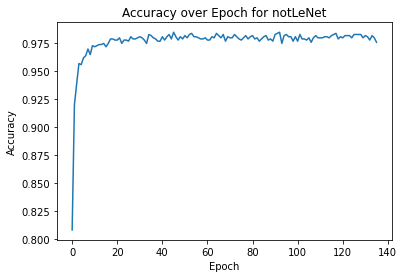

In [22]:
vwr.plotAccHist(notLenet.name, notLenet.accHist())

In [23]:
notLenet.test(trainingSigns.data())

Model-0808 | notLeNet restored.
Model-0808 | Test accuracy: 1.000.


In [24]:
notLenet.test(testSigns.data())

Model-0808 | notLeNet restored.
Model-0808 | Test accuracy: 0.959.


In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

folder_name = 'traffic_signs/wikipedia/'
wiki_traffic_signs = TrafficSignsDataset (folder_name, n_classes)

TrafficSignsDataset-0904 | Loading signs from traffic_signs/wikipedia/...
TrafficSignsDataset-0904 | Loaded 10,No passing for vehicles over 3.5 metric tons.png with label 10.
TrafficSignsDataset-0904 | Loaded 19,Dangerous curve to the left.png with label 19.
TrafficSignsDataset-0904 | Loaded 21,Double curve.png with label 21.
TrafficSignsDataset-0904 | Loaded 22,Bumpy road.png with label 22.
TrafficSignsDataset-0904 | Loaded 24,Road narrows on the right.png with label 24.
TrafficSignsDataset-0904 | Loaded 26,Traffic signals.png with label 26.
TrafficSignsDataset-0904 | Loaded 29,Bicycles crossing.png with label 29.
TrafficSignsDataset-0904 | Loaded 3,Speed limit (60kmh).png with label 3.
TrafficSignsDataset-0904 | Loaded 30,Beware of ice-snow.png with label 30.
TrafficSignsDataset-0904 | Loaded 32,End of all speed and passing limits.png with label 32.
TrafficSignsDataset-0904 | Loaded 35,Ahead only.png with label 35.
TrafficSignsDataset-0904 | Loaded 40,Roundabout mandatory.png with la

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

wiki_traffic_signs.restoreOrgImages()
wiki_traffic_signs.processImages(image_processors)


TrafficSignsDataset-0904 | Original images and labels restored.
TrafficSignsDataset-0904 | Processing images...
TrafficSignsDataset-0904 | Applying equalizeHist() to images.
TrafficSignsDataset-0904 | Applying RGB_to_norm() to images.
TrafficSignsDataset-0904 | ...images processed.


Model-0808 | notLeNet restored.
Model-0808 | Classifying images...
Model-0808 | ...13 images classified.


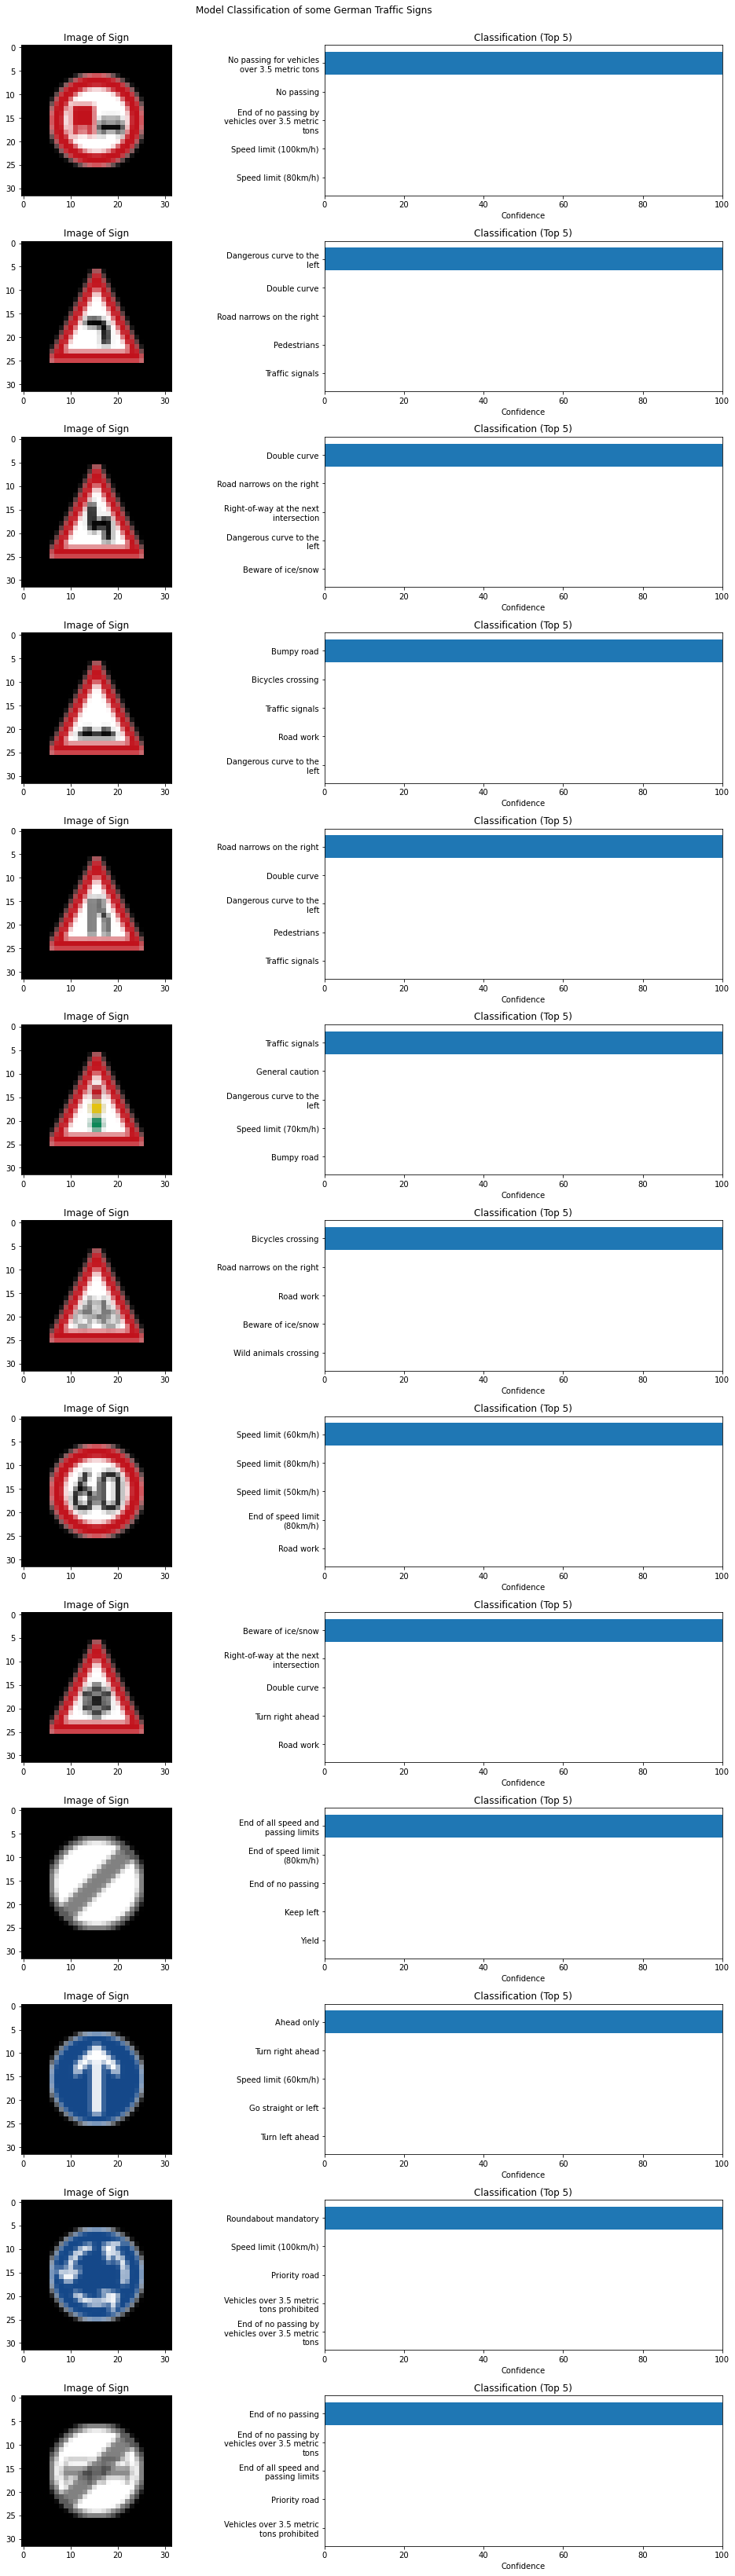

In [27]:
predictions = notLenet.predict(wiki_traffic_signs.X, top=5)

vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

In [49]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
notLenet.test(wiki_traffic_signs.data())

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_12 not found in checkpoint
	 [[node save_6/RestoreV2 (defined at C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'save_6/RestoreV2':
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\kernelbase.py", line 362, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\kernelbase.py", line 265, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tornado\gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-a96431d77e92>", line 3, in <module>
    notLenet.test(wiki_traffic_signs.data())
  File "<ipython-input-19-90ed65ce73d8>", line 152, in test
    self.restore()
  File "<ipython-input-19-90ed65ce73d8>", line 181, in restore
    saver = tf.train.Saver()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 828, in __init__
    self.build()
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 878, in _build
    build_restore=build_restore)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\training\saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\ops\gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\Owner\anaconda3\envs\tsc\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


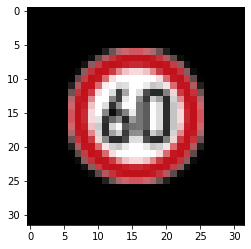

In [74]:
plt.imshow(wiki_traffic_signs.org_X[7])

In [77]:
layer_outputs = notLenet.eval_layer(0, wiki_traffic_signs.X[7])

Model-7088 | Evaluating layer 0.
Model-7088 | notLeNet restored.
Model-7088 | Output shape: (1, 32, 32, 1).


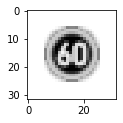

In [78]:
vwr.imShowConvOutputs(layer_outputs)

In [79]:
layer_outputs = notLenet.eval_layer(1, wiki_traffic_signs.X[7])

Model-7088 | Evaluating layer 1.
Model-7088 | notLeNet restored.
Model-7088 | Output shape: (1, 28, 28, 24).


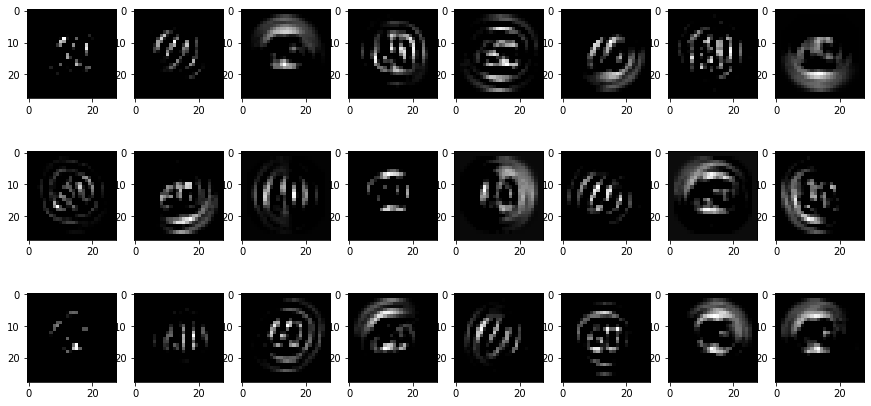

In [80]:
vwr.imShowConvOutputs(layer_outputs)

In [34]:
class Concatenate(Layer):
    
    def setName(self):
        self.name = "Concatenate"
        return

    def connect(self, *prev_layers):
        self.model = prev_layers[0].model
        tensors = [layer.tensor for layer in prev_layers]
        self.tensor = tf.concat(tensors, axis=1)
        return self


In [35]:
tf.reset_default_graph()

notSermanet = Model("notSermanet", image_shape, n_classes)

stage_1x1 = Conv2D ([32, 32, 1]).connect(notSermanet.inputLayer())

stage_1 = Conv2D ([28, 28, 24]).connect(stage_1x1)
stage_1 = Pooling([14, 14]).connect(stage_1)
flatten_1 = Flatten().connect(stage_1)

stage_2 = Conv2D ([10, 10, 64]).connect(stage_1)
stage_2 = Pooling([ 5,  5]).connect(stage_2)
stage_2 = Conv2D ([3, 3, 96]).connect(stage_2)
flatten_2 = Flatten().connect(stage_2)

stage_3 = Concatenate().connect(flatten_1, flatten_2)
stage_3 = Connected([240]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)
stage_3 = Connected([168]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)

notSermanet.connectLogits(stage_3)


In [36]:
notSermanet.train(trainingSigns.data(), validSigns.data(), batch_size=336, 
        epochs_done=128, acc_done=0.997, keep_prob=0.5)

Model-1920 | Training...
Model-1920 | Epoch    1 - Acc: 0.759
Model-1920 | Epoch    2 - Acc: 0.895
Model-1920 | Epoch    3 - Acc: 0.928
Model-1920 | Epoch    4 - New High Acc: 0.940
Model-1920 | notSermanet saved.
Model-1920 | Epoch    5 - New High Acc: 0.953
Model-1920 | notSermanet saved.
Model-1920 | Epoch    6 - New High Acc: 0.962
Model-1920 | notSermanet saved.
Model-1920 | Epoch    7 - New High Acc: 0.969
Model-1920 | notSermanet saved.
Model-1920 | Epoch    8 - Acc: 0.968 - Highest: 0.969
Model-1920 | Epoch    9 - Acc: 0.966 - Highest: 0.969
Model-1920 | Epoch   10 - New High Acc: 0.970
Model-1920 | notSermanet saved.
Model-1920 | Epoch   11 - New High Acc: 0.972
Model-1920 | notSermanet saved.
Model-1920 | Epoch   12 - New High Acc: 0.975
Model-1920 | notSermanet saved.
Model-1920 | Epoch   13 - Acc: 0.971 - Highest: 0.975
Model-1920 | Epoch   14 - Acc: 0.973 - Highest: 0.975
Model-1920 | Epoch   15 - Acc: 0.974 - Highest: 0.975
Model-1920 | Epoch   16 - Acc: 0.975 - Highest: 

Model-1920 | Epoch  147 - Acc: 0.982 - Highest: 0.985
Model-1920 | Epoch  148 - Acc: 0.982 - Highest: 0.985
Model-1920 | Epoch  149 - Acc: 0.977 - Highest: 0.985
Model-1920 | Epoch  150 - Acc: 0.978 - Highest: 0.985
Model-1920 | Epoch  151 - Acc: 0.980 - Highest: 0.985
Model-1920 | Epoch  152 - Acc: 0.978 - Highest: 0.985
Model-1920 | Epoch  153 - Acc: 0.983 - Highest: 0.985
Model-1920 | Epoch  154 - Acc: 0.984 - Highest: 0.985
Model-1920 | Epoch  155 - Acc: 0.978 - Highest: 0.985
Model-1920 | Epoch  156 - Acc: 0.978 - Highest: 0.985
Model-1920 | Epoch  157 - Acc: 0.982 - Highest: 0.985
Model-1920 | Epoch  158 - Acc: 0.981 - Highest: 0.985
Model-1920 | Epoch  159 - Acc: 0.979 - Highest: 0.985
Model-1920 | Epoch  160 - Acc: 0.980 - Highest: 0.985
Model-1920 | Epoch  161 - Acc: 0.981 - Highest: 0.985
Model-1920 | Epoch  162 - Acc: 0.978 - Highest: 0.985
Model-1920 | Epoch  163 - Acc: 0.983 - Highest: 0.985
Model-1920 | Epoch  164 - Acc: 0.983 - Highest: 0.985
Model-1920 | Epoch  165 - Ac

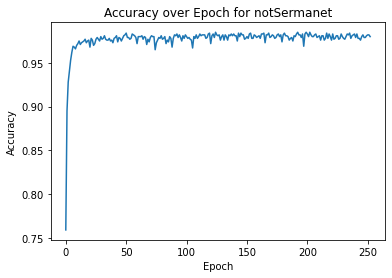

In [37]:
vwr.plotAccHist(notSermanet.name, notSermanet.accHist())

In [38]:
notSermanet.test(trainingSigns.data())

Model-1920 | notSermanet restored.
Model-1920 | Test accuracy: 1.000.


In [39]:
notSermanet.test(testSigns.data())

Model-1920 | notSermanet restored.
Model-1920 | Test accuracy: 0.961.


Model-1920 | notSermanet restored.
Model-1920 | Classifying images...
Model-1920 | ...13 images classified.


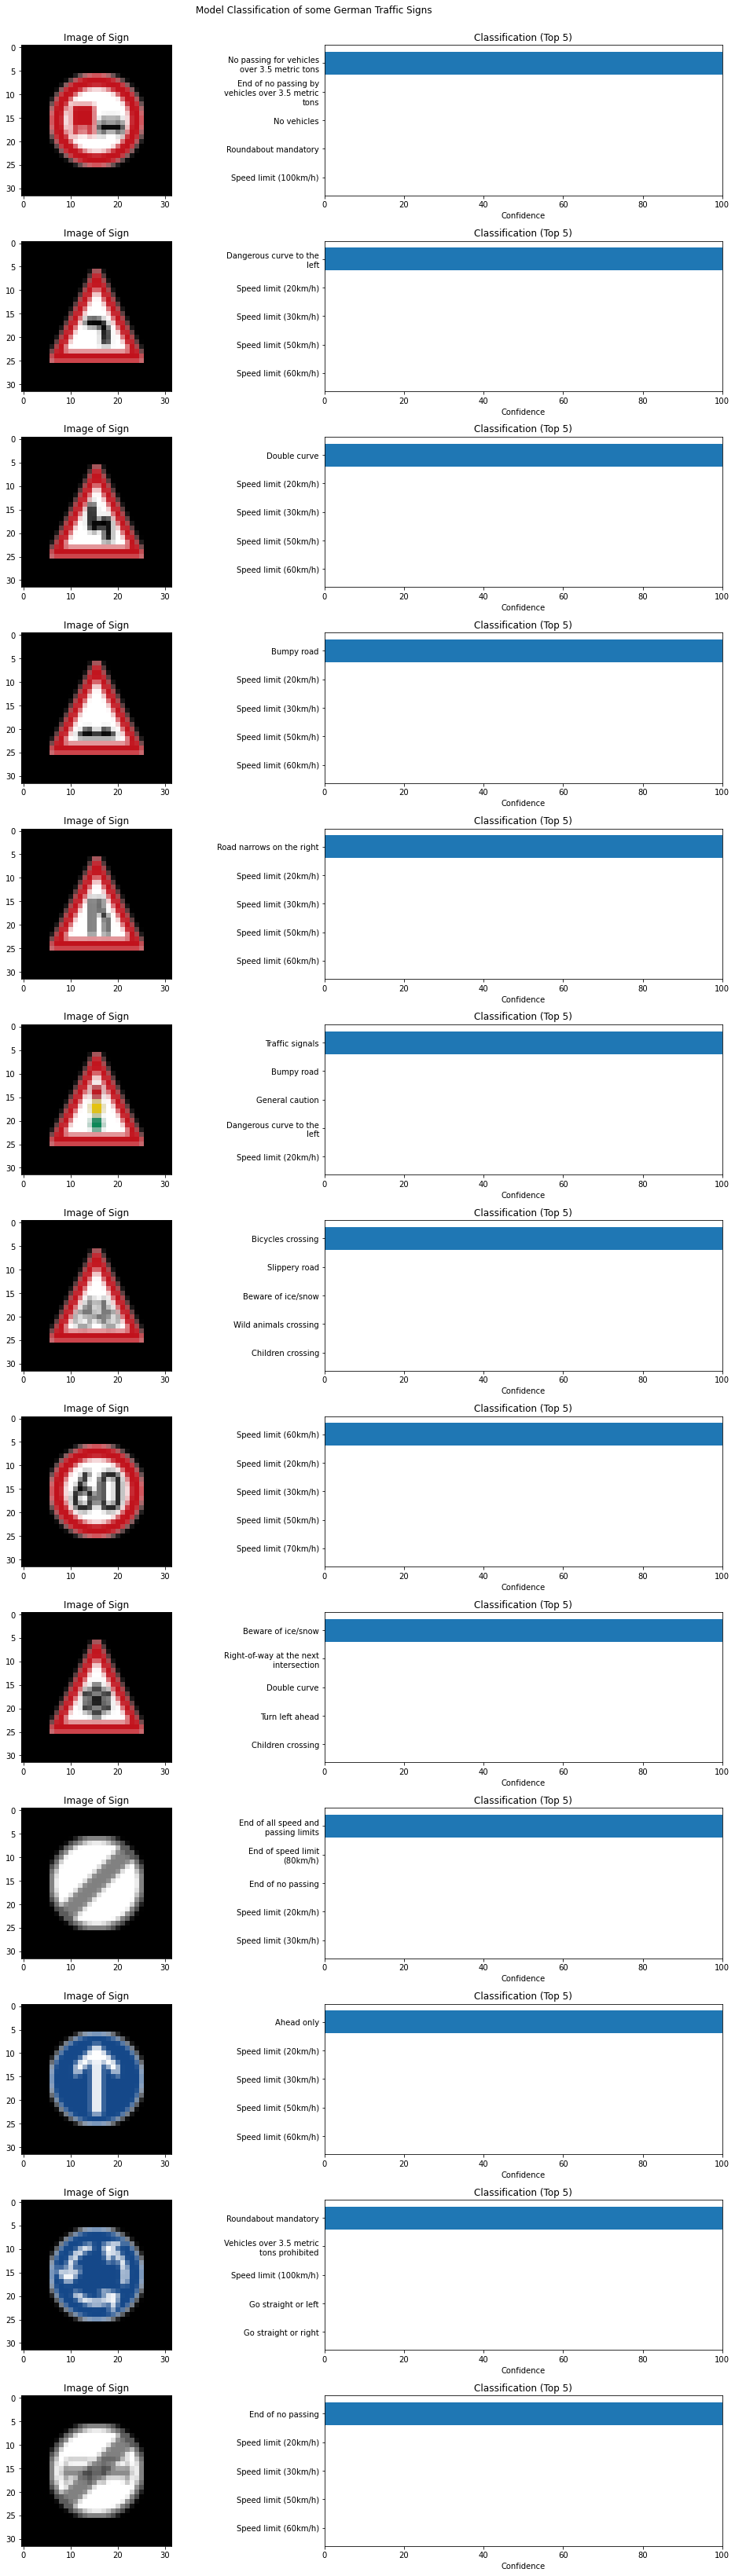

In [40]:
predictions = notSermanet.predict(wiki_traffic_signs.X, top=5)

vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

In [41]:
notSermanet.test(wiki_traffic_signs.data())

Model-1920 | notSermanet restored.
Model-1920 | Test accuracy: 1.000.
